### Imports

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Training: Define directories and filenames
csv = ".csv"
dir = "CSVS_/"
filenames = ["1_foreleg", "2_midleg", "3_hindleg"]
downsampled_suffix = "_downsampled"
prediction_suffix = "_gian_predictions"
weights_suffix = "_gian_weights"
centers_suffix = "_gian_centers"
kernels_suffix = "_gian_kernels"

filename = dir + filenames[0]

Resapling = False
Tidy_up = True
Write_to_csv = True
For_all_files = True
use_default_kernels = True
use_steps_eq_kernels = True
read_CPGs_from_file = True

## Downsample Function

In [15]:
def downsample_to_target(csv_file, target_samples):
    '''
    np.linspace(0, len(df_resample[column]) - 1, target_samples):  we
    Generates an array of target_samples evenly spaced values between 0 and the length of the column minus 1. 
    These values represent the new x-coordinates for the interpolated data points.

    np.arange(len(df[column])): 
    Generates an array of integers from 0 to the length of the column minus 1. 
    These values represent the original x-coordinates of the data points.

    df[column].values: 
    Accesses the values of the DataFrame column specified by column as a NumPy array. 
    These values represent the y-coordinates of the data points.

    np.interp(): 
    This function performs linear interpolation between the points given by the original x-coordinates (np.arange(len(df[column]))) and 
    their corresponding y-coordinates (df[column].values) to estimate the values at the new x-coordinates (np.linspace(0, len(df[column]) - 1, target_samples)).
    '''
    df_resample = pd.read_csv(csv_file)
    downsampled_df = pd.DataFrame()

    for column in df_resample.columns:
        if df_resample[column].dtype != 'object':  # Skip object type columns
            downsampled_column = np.interp(np.linspace(0, len(df_resample[column]) - 1, target_samples),
                                            np.arange(len(df_resample[column])),
                                            df_resample[column].values)
            downsampled_df[column] = downsampled_column

    return downsampled_df

if Resapling:
    if For_all_files:
        for filename in filenames:
            csv_file = dir + filename + csv
            df_resample = downsample_to_target(csv_file, 40)
            output_csv = csv_file.replace(csv, downsampled_suffix + csv)
            df_resample.to_csv(output_csv, index=False)
    else:
        csv_file = "CSVS_/1_foreleg.csv"
        #csv_file = "CSVS_/2_midleg.csv"
        #csv_file = "CSVS_/3_hindleg.csv"
        df_resample = downsample_to_target(csv_file, 40)
        output_csv = csv_file.replace('.csv', '_downsampled.csv')
        df_resample.to_csv(output_csv, index=False)

## Initialization of the parameters (w_d0, w_d1...)




In [16]:
SIGMA = 0.2 #0.4 # 0.4 #from the article
LR = 0.01 # Learning rate
W_D0 = 1.4  # Default synaptic weight
W_D1 = 0.18  # Default synaptic weight
ALPHA = 0.01  # Synaptic plasticity
MI = 0.1  # Extrinsic modulatory input
S1 = np.ones(100)
S2 = np.ones(100)
O_N1 = 0.0
O_N2 = 0.2
N_KERNELS = 40
NUM_STEPS = 100

## Create the class for the CPG and RBF

In [17]:
# Create the CPG Class
class CPG:
    def __init__(self):
        self.w_11 = W_D0  # Fixed synaptic weight (self-connection weights)
        self.w_22 = W_D0  # Fixed synaptic weight (self-connection weights)
        self.w_12 = W_D1 + MI  # Modulated synaptic weight (cross-connection weights)
        self.w_21 = -W_D1 - MI  # Modulated synaptic weight (cross-connection weights)
        self.alpha = ALPHA  # synaptic plasticity

    def update(self, o_N1, o_N2, S1, S2):
        o_N1 = np.tanh(self.w_11 * o_N1 + self.w_12 * o_N2 + self.alpha * S1)
        o_N2 = np.tanh(self.w_22 * o_N2 + self.w_21 * o_N1 + self.alpha * S2)
        return o_N1, o_N2

# Create the RBF Class
class RBF:
    def __init__(self, sigma):
        self.sigma = sigma

    def get_activation(self, cpg_1, cpg_2, mu_1, mu_2):
        """
        Gaussian activation function, based on the distance between the CPG outputs and the RBF kernels
        """
        return np.exp(
            -((cpg_1 - mu_1) ** 2 + (cpg_2 - mu_2) ** 2) / (2 * self.sigma**2)
        )


## Initialization for Simulation and Training

In [20]:
def Initialize_training(df):
    if use_default_kernels:
            N_Kernels = N_KERNELS
    else:
        N_Kernels = df.shape[0]
    print (N_Kernels)
    if use_steps_eq_kernels:
        num_steps = N_Kernels
    else:
        num_steps = NUM_STEPS
    
    means_kern_pos = np.linspace(0, num_steps - 1, N_Kernels).astype(int)  # Cast to integer values because they are positions
    print(means_kern_pos)
    return num_steps, N_Kernels, means_kern_pos

## Try with joe's centers and train teh weights

In [6]:
data = np.loadtxt('Joe_weights_centers/rbfn_centers.txt', delimiter=',')
if For_all_files:
    for file in filenames:
        # Initialize the Dataframe for training
        df = pd.read_csv(filename+downsampled_suffix+csv)
        num_steps, N_Kernels, means_kern_pos = Initialize_training(df)
        x = np.arange(num_steps)

        # Initialize the output DataFrame
        output_predictions_df = pd.DataFrame()
        W_trained_df = pd.DataFrame()
        kernels_df = pd.DataFrame()

        # Initialize Training Parameters
        output = 0
        delta_w = 0
        err_threshold = 0
        epochs = 10000
        precision = 0.01
        W = np.ones(N_Kernels)  # Weights

        # Create CPG and RBF instances
        cpg = CPG()
        rbf = RBF(SIGMA)

        for column in df.columns:
        #Skip object type columns    
            if df[column].dtype != 'object': 
                target = df[column].values
        
        #-------------- Simulation Loop --------------#
                if read_CPGs_from_file:
                    # Lists to store CPG outputs for plotting
                    output_1_cpg = data[:, 0]
                    output_2_cpg = data[:, 1]
                else:
                    # Initialize CPG outputs
                    o_N1 = O_N1 #0.0
                    o_N2 = O_N2 #0.0
                    # Simulation loop: CPG
                    for i in range(num_steps):
                        o_N1, o_N2 = cpg.update(o_N1, o_N2, S1[i], S2[i])
                        # print(o_N1, o_N2)
                        output_1_cpg.append(o_N1)
                        output_2_cpg.append(o_N2)
                # Lists to store RBF outputs for plotting
                kernels = []
                centers = []
                # Simulation loop: RBF
                for j in means_kern_pos:
                    kernel = []
                    for i in range(num_steps):
                        phi = rbf.get_activation(
                            output_1_cpg[i], output_2_cpg[i], output_1_cpg[j], output_2_cpg[j]
                        )
                        center = [output_1_cpg[j], output_2_cpg[j]]
                        kernel.append(phi)
                    kernels.append(kernel)
                    centers.append(center)
                    #print(kernels)
                # Convert the list to a numpy array
                kernels = np.array(kernels)
                kernels_df = pd.DataFrame(kernels)

                print(column)


        #-------------- Training Loop --------------#
            for t in range(epochs):
                err_threshold=0 # every epoch, reset the error threshold
                if t%1000 == 0: # print the epoch number every 1000 epochs
                    print(t)
        # Calculate the output of the RBF layer 
        # by iterating through the positions of the kernels
        # k = index, means_kern_pos[k] = value
                for k,mean_pos in enumerate(means_kern_pos):
                    output = 0
        #Cycle through the kernels calculating the output of every kernel
                    for i in range(N_KERNELS):
                        output += kernels[i][mean_pos] * W[i]
                        #print(kernels[i][mean_pos])
        # Calculate the error at the current index based on the calculated output
                    error = target[mean_pos] - output
                    delta_w = LR * error 
        # Update the weights based on the error
                    W[k] = W[k] + delta_w
        # Check for the error threshold, using abs to check the surronding of the target
                    if abs(error) > err_threshold:
                        err_threshold = abs(error)
                if err_threshold < precision:
                    break
        # Append the trained weights to the trained_weights_df
            W_trained_df[column] = W.tolist()
        # See training results
            outputs = []
            for j in range(num_steps):
                output = 0
                for i in range(N_KERNELS):
                    output += kernels[i][j] * W[i]
        # Append the output to the outputs list
                outputs.append(output)

        # Convert the outputs list to a DataFrame
            output_predictions_df[column] = outputs
            

        # Convert the centers list to a DataFrame
        centers_df = pd.DataFrame(centers)

        if Write_to_csv:
            output_predictions_df.to_csv(filename + prediction_suffix + ".csv", index=False)
            W_trained_df.to_csv(filename + weights_suffix + ".csv", index=False)
            centers_df.to_csv(filename + centers_suffix + ".csv", index=False)
            kernels_df.to_csv(filename + kernels_suffix + ".csv", index=False)
else:
    # Initialize Training Parameters
    output = 0
    delta_w = 0
    err_threshold = 0
    epochs = 10000
    precision = 0.01
    for column data = np.loadtxt('Joe_weights_centers/rbfn_centers.txt', delimiter=',')---- Simulation Loop --------------#
            # Lists to store CPG outputs for plotting
            output_1_cpg = []
            output_2_cpg = []
            # Initialize CPG outputs
            o_N1 = O_N1 #0.0
            o_N2 = O_N2 #0.0
            # Simulation loop: CPG
            for i in range(100):
                o_N1, o_N2 = cpg.update(o_N1, o_N2, S1[i], S2[i])
                # print(o_N1, o_N2)
                output_1_cpg.append(o_N1)
                output_2_cpg.append(o_N2)
            output_1_cpg = output_1_cpg[15:55]
            output_2_cpg = output_2_cpg[15:55]
            # Lists to store RBF outputs for plotting
            kernels = []
            centers = []
            # Simulation loop: RBF
            for j in means_kern_pos:
                kernel = []
                for i in range(num_steps):
                    phi = rbf.get_activation(
                        output_1_cpg[i], output_2_cpg[i], output_1_cpg[j], output_2_cpg[j]
                    )
                    center = [output_1_cpg[j], output_2_cpg[j]]
                    kernel.append(phi)
                kernels.append(kernel)
                centers.append(center)
                #print(kernels)
            # Convert the list to a numpy array
            kernels = np.array(kernels)

            print(column)


    #-------------- Training Loop --------------#
        for t in range(epochs):
            err_threshold=0 # every epoch, reset the error threshold
            if t%1000 == 0: # print the epoch number every 1000 epochs
                print(t)
    # Calculate the output of the RBF layer 
    # by iterating through the positions of the kernels
    # k = index, means_kern_pos[k] = value
            for k,mean_pos in enumerate(means_kern_pos):
                output = 0
    #Cycle through the kernels calculating the output of every kernel
                for i in range(N_KERNELS):
                    output += kernels[i][mean_pos] * W[i]
                    #print(kernels[i][mean_pos])
    # Calculate the error at the current index based on the calculated output
                error = target[mean_pos] - output
                delta_w = LR * error 
    # Update the weights based on the error
                W[k] = W[k] + delta_w
    # Check for the error threshold, using abs to check the surronding of the target
                if abs(error) > err_threshold:
                    err_threshold = abs(error)
            if err_threshold < precision:
                break
    # Append the trained weights to the trained_weights_df
        W_trained_df[column] = W.tolist()
    # See training results
        outputs = []
        for j in range(num_steps):
            output = 0
            for i in range(N_KERNELS):
                output += kernels[i][j] * W[i]
    # Append the output to the outputs list
            outputs.append(output)


    # Convert the outputs list to a DataFrame
        output_predictions_df[column] = outputs

jointFR1
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
jointFR2
0
1000
2000
3000
4000
5000
6000
7000
jointFR3
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
footFRx
0
1000
2000
3000
4000
5000
6000
footFRy
0
footFRz
0
force_sign_FR
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
jointMR1
0
1000
2000
3000
4000
jointMR2
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
jointMR3
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
footMRx
0
1000
2000
3000
4000
footMRy
0
footMRz
0
1000
2000
force_sign_MR
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
jointHR1
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
jointHR2
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
jointHR3
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
footHRx
0
1000
2000
footHRy
0
footHRz
0
1000
force_sign_HR
0
1000
2000
3000
4000
5000
6000
7000
8000
9000


## Try to create a CPG for 100 step and cut it to 40 step

In [116]:
if For_all_files:
    for file in filenames:
        filename = dir + file
        df = pd.read_csv(filename + ".csv")
        N_KERNELS= df.shape[0]

        num_steps = N_KERNELS # Number of time steps
        means_kern_pos = np.linspace(0, num_steps - 1, N_KERNELS).astype(int)  # Cast to integer values because they are positions

        W = np.ones(N_KERNELS)  # Weights

        # Initialize the output DataFrame
        output_predictions_df = pd.DataFrame()
        W_trained_df = pd.DataFrame()
        kernels_df = pd.DataFrame()

        # Initialize Training Parameters
        output = 0
        delta_w = 0
        err_threshold = 0
        epochs = 10000
        precision = 0.01

        x = np.arange(num_steps)
        S1 = np.ones(100) #np.sin(0.1*x)  _df
        S2 = np.ones(100) #np.cos(0.1*x)  
        # Create CPG and RBF instances
        cpg = CPG()
        rbf = RBF(SIGMA)

        for column in df.columns:
        #Skip object type columns    
            if df[column].dtype != 'object': 
                target = df[column].values

        #-------------- Simulation Loop --------------#
                # Lists to store CPG outputs for plotting
                output_1_cpg = []
                output_2_cpg = []
                # Initialize CPG outputs
                o_N1 = O_N1 #0.0
                o_N2 = O_N2 #0.0
                # Simulation loop: CPG
                for i in range(100):
                    o_N1, o_N2 = cpg.update(o_N1, o_N2, S1[i], S2[i])
                    # print(o_N1, o_N2)
                    output_1_cpg.append(o_N1)
                    output_2_cpg.append(o_N2)
                output_1_cpg = output_1_cpg[10:50]
                output_2_cpg = output_2_cpg[10:50]
                # Lists to store RBF outputs for plotting
                kernels = []
                centers = []
                # Simulation loop: RBF
                for j in means_kern_pos:
                    kernel = []
                    for i in range(num_steps):
                        phi = rbf.get_activation(
                            output_1_cpg[i], output_2_cpg[i], output_1_cpg[j], output_2_cpg[j]
                        )
                        center = [output_1_cpg[j], output_2_cpg[j]]
                        kernel.append(phi)
                    kernels.append(kernel)
                    centers.append(center)
                    #print(kernels)
                # Convert the list to a numpy array
                kernels = np.array(kernels)
                kernels_df = pd.DataFrame(kernels)

                print(column)


        #-------------- Training Loop --------------#
            for t in range(epochs):
                err_threshold=0 # every epoch, reset the error threshold
                if t%1000 == 0: # print the epoch number every 1000 epochs
                    print(t)
        # Calculate the output of the RBF layer 
        # by iterating through the positions of the kernels
        # k = index, means_kern_pos[k] = value
                for k,mean_pos in enumerate(means_kern_pos):
                    output = 0
        #Cycle through the kernels calculating the output of every kernel
                    for i in range(N_KERNELS):
                        output += kernels[i][mean_pos] * W[i]
                        #print(kernels[i][mean_pos])
        # Calculate the error at the current index based on the calculated output
                    error = target[mean_pos] - output
                    delta_w = LR * error 
        # Update the weights based on the error
                    W[k] = W[k] + delta_w
        # Check for the error threshold, using abs to check the surronding of the target
                    if abs(error) > err_threshold:
                        err_threshold = abs(error)
                if err_threshold < precision:
                    break
        # Append the trained weights to the trained_weights_df
            W_trained_df[column] = W.tolist()
        # See training results
            outputs = []
            for j in range(num_steps):
                output = 0
                for i in range(N_KERNELS):
                    output += kernels[i][j] * W[i]
        # Append the output to the outputs list
                outputs.append(output)

        # Convert the outputs list to a DataFrame
            output_predictions_df[column] = outputs
            

        # Convert the centers list to a DataFrame
        centers_df = pd.DataFrame(centers)

        if Write_to_csv:
            output_predictions_df.to_csv(filename + prediction_suffix + ".csv", index=False)
            W_trained_df.to_csv(filename + weights_suffix + ".csv", index=False)
            centers_df.to_csv(filename + centers_suffix + ".csv", index=False)
            kernels_df.to_csv(filename + kernels_suffix + ".csv", index=False)
else:
    # Initialize Training Parameters
    output = 0
    delta_w = 0
    err_threshold = 0
    epochs = 10000
    precision = 0.01
    for column in df.columns:
    #Skip object type columns    
        if df[column].dtype != 'object': 
            target = df[column].values

    #-------------- Simulation Loop --------------#
            # Lists to store CPG outputs for plotting
            output_1_cpg = []
            output_2_cpg = []
            # Initialize CPG outputs
            o_N1 = O_N1 #0.0
            o_N2 = O_N2 #0.0
            # Simulation loop: CPG
            for i in range(100):
                o_N1, o_N2 = cpg.update(o_N1, o_N2, S1[i], S2[i])
                # print(o_N1, o_N2)
                output_1_cpg.append(o_N1)
                output_2_cpg.append(o_N2)
            output_1_cpg = output_1_cpg[15:55]
            output_2_cpg = output_2_cpg[15:55]
            # Lists to store RBF outputs for plotting
            kernels = []
            centers = []
            # Simulation loop: RBF
            for j in means_kern_pos:
                kernel = []
                for i in range(num_steps):
                    phi = rbf.get_activation(
                        output_1_cpg[i], output_2_cpg[i], output_1_cpg[j], output_2_cpg[j]
                    )
                    center = [output_1_cpg[j], output_2_cpg[j]]
                    kernel.append(phi)
                kernels.append(kernel)
                centers.append(center)
                #print(kernels)
            # Convert the list to a numpy array
            kernels = np.array(kernels)

            print(column)


    #-------------- Training Loop --------------#
        for t in range(epochs):
            err_threshold=0 # every epoch, reset the error threshold
            if t%1000 == 0: # print the epoch number every 1000 epochs
                print(t)
    # Calculate the output of the RBF layer 
    # by iterating through the positions of the kernels
    # k = index, means_kern_pos[k] = value
            for k,mean_pos in enumerate(means_kern_pos):
                output = 0
    #Cycle through the kernels calculating the output of every kernel
                for i in range(N_KERNELS):
                    output += kernels[i][mean_pos] * W[i]
                    #print(kernels[i][mean_pos])
    # Calculate the error at the current index based on the calculated output
                error = target[mean_pos] - output
                delta_w = LR * error 
    # Update the weights based on the error
                W[k] = W[k] + delta_w
    # Check for the error threshold, using abs to check the surronding of the target
                if abs(error) > err_threshold:
                    err_threshold = abs(error)
            if err_threshold < precision:
                break
    # Append the trained weights to the trained_weights_df
        W_trained_df[column] = W.tolist()
    # See training results
        outputs = []
        for j in range(num_steps):
            output = 0
            for i in range(N_KERNELS):
                output += kernels[i][j] * W[i]
    # Append the output to the outputs list
            outputs.append(output)


    # Convert the outputs list to a DataFrame
        output_predictions_df[column] = outputs

jointFR1
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
jointFR2
0
1000
jointFR3
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
footFRx
0
1000
2000
3000
4000
footFRy
0
footFRz
0
1000
2000
force_sign_FR
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
jointMR1
0
1000
2000
jointMR2
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
jointMR3
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
footMRx
0
1000
2000
3000
4000
footMRy
0
footMRz
0
1000
2000
3000
force_sign_MR
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
jointHR1
0
1000
2000
3000
4000
5000
jointHR2
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
jointHR3
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
footHRx
0
1000
footHRy
0
footHRz
0
1000
2000
force_sign_HR
0
1000
2000
3000
4000
5000
6000
7000
8000
9000


## Simulation with CPGs and RBFn

I am simulating by generating arrays with size = num_steps and print them as graphs

The output signals from the RBF neurons are linearly combined at four linear output neurons as:
$$
o_{R B F_j}(t)=\sum_{n=1}^N w_{j n} \phi_n(t), j \in 1, \ldots, 4,
$$
$w_{j n}$ represents the weights used to shape and combine the transmitted signals between the RBF hidden and output neurons. 

The first three output neurons are used as three motor neurons $\left(\mathrm{M}_{1, \ldots, 3}\right.)$ for controlling the TC-, CTr-, and FTi-joints and the last output neuron as a forward model neuron FP for predicting foot contact feedback. 

This RBF premotor network structure is the same for all six neural control systems controlling the six legs of the robot. 

The output weights $w_{j n}$ are trained offline using a delta or error-based learning rule as follows:
$$
\Delta \mathrm{w}_{j n}=\eta\left(T_j(t)-\sum_{n=1}^N w_{j n} \phi_n(t)\right), j \in 1, \ldots, 4, n \in 1, \ldots, N .
$$

## Simulate and Training the RBF for an entire target


In [98]:
if For_all_files:
    for file in filenames:
        filename = dir + file
        df = pd.read_csv(filename + ".csv")
        N_KERNELS= df.shape[0]

        num_steps = N_KERNELS # Number of time steps
        means_kern_pos = np.linspace(0, num_steps - 1, N_KERNELS).astype(int)  # Cast to integer values because they are positions

        W = np.ones(N_KERNELS)  # Weights

        # Initialize the output DataFrame
        output_predictions_df = pd.DataFrame()
        W_trained_df = pd.DataFrame()
        kernels_df = pd.DataFrame()

        # Initialize Training Parameters
        output = 0
        delta_w = 0
        err_threshold = 0
        epochs = 10000
        precision = 0.01

        x = np.arange(num_steps)
        S1 = np.ones(num_steps) #np.sin(0.1*x)  _df
        S2 = np.ones(num_steps) #np.cos(0.1*x)  
        # Create CPG and RBF instances
        cpg = CPG()
        rbf = RBF(SIGMA)

        for column in df.columns:
        #Skip object type columns    
            if df[column].dtype != 'object': 
                target = df[column].values

        #-------------- Simulation Loop --------------#
                # Lists to store CPG outputs for plotting
                output_1_cpg = []
                output_2_cpg = []
                # Initialize CPG outputs
                o_N1 = O_N1 #0.0
                o_N2 = O_N2 #0.0
                # Simulation loop: CPG
                for i in range(num_steps):
                    o_N1, o_N2 = cpg.update(o_N1, o_N2, S1[i], S2[i])
                    # print(o_N1, o_N2)
                    output_1_cpg.append(o_N1)
                    output_2_cpg.append(o_N2)
                # Lists to store RBF outputs for plotting
                kernels = []
                centers = []
                # Simulation loop: RBF
                for j in means_kern_pos:
                    kernel = []
                    for i in range(num_steps):
                        phi = rbf.get_activation(
                            output_1_cpg[i], output_2_cpg[i], output_1_cpg[j], output_2_cpg[j]
                        )
                        center = [output_1_cpg[j], output_2_cpg[j]]
                        kernel.append(phi)
                    kernels.append(kernel)
                    centers.append(center)
                    #print(kernels)
                # Convert the list to a numpy array
                kernels = np.array(kernels)
                kernels_df = pd.DataFrame(kernels)

                print(column)


        #-------------- Training Loop --------------#
            for t in range(epochs):
                err_threshold=0 # every epoch, reset the error threshold
                if t%1000 == 0: # print the epoch number every 1000 epochs
                    print(t)
        # Calculate the output of the RBF layer 
        # by iterating through the positions of the kernels
        # k = index, means_kern_pos[k] = value
                for k,mean_pos in enumerate(means_kern_pos):
                    output = 0
        #Cycle through the kernels calculating the output of every kernel
                    for i in range(N_KERNELS):
                        output += kernels[i][mean_pos] * W[i]
                        #print(kernels[i][mean_pos])
        # Calculate the error at the current index based on the calculated output
                    error = target[mean_pos] - output
                    delta_w = LR * error 
        # Update the weights based on the error
                    W[k] = W[k] + delta_w
        # Check for the error threshold, using abs to check the surronding of the target
                    if abs(error) > err_threshold:
                        err_threshold = abs(error)
                if err_threshold < precision:
                    break
        # Append the trained weights to the trained_weights_df
            W_trained_df[column] = W.tolist()
        # See training results
            outputs = []
            for j in range(num_steps):
                output = 0
                for i in range(N_KERNELS):
                    output += kernels[i][j] * W[i]
        # Append the output to the outputs list
                outputs.append(output)

        # Convert the outputs list to a DataFrame
            output_predictions_df[column] = outputs
            

        # Convert the centers list to a DataFrame
        centers_df = pd.DataFrame(centers)

        if Write_to_csv:
            output_predictions_df.to_csv(filename + prediction_suffix + ".csv", index=False)
            W_trained_df.to_csv(filename + weights_suffix + ".csv", index=False)
            centers_df.to_csv(filename + centers_suffix + ".csv", index=False)
            kernels_df.to_csv(filename + kernels_suffix + ".csv", index=False)
else:
    # Initialize Training Parameters
    output = 0
    delta_w = 0
    err_threshold = 0
    epochs = 10000
    precision = 0.01
    for column in df.columns:
    for column in df.columns:
    #Skip object type columns    
        if df[column].dtype != 'object': 
            target = df[column].values

    #-------------- Simulation Loop --------------#
            # Lists to store CPG outputs for plotting
            output_1_cpg = []
            output_2_cpg = []
            # Initialize CPG outputs
            o_N1 = O_N1 #0.0
            o_N2 = O_N2 #0.0
            # Simulation loop: CPG
            for i in range(num_steps):
                o_N1, o_N2 = cpg.update(o_N1, o_N2, S1[i], S2[i])
                # print(o_N1, o_N2)
                output_1_cpg.append(o_N1)
                output_2_cpg.append(o_N2)
            # Lists to store RBF outputs for plotting
            kernels = []
            centers = []
            # Simulation loop: RBF
            for j in means_kern_pos:
                kernel = []
                for i in range(num_steps):
                    phi = rbf.get_activation(
                        output_1_cpg[i], output_2_cpg[i], output_1_cpg[j], output_2_cpg[j]
                    )
                    center = [output_1_cpg[j], output_2_cpg[j]]
                    kernel.append(phi)
                kernels.append(kernel)
                centers.append(center)
                #print(kernels)
            # Convert the list to a numpy array
            kernels = np.array(kernels)

            print(column)


    #-------------- Training Loop --------------#
        for t in range(epochs):
            err_threshold=0 # every epoch, reset the error threshold
            if t%1000 == 0: # print the epoch number every 1000 epochs
                print(t)
    # Calculate the output of the RBF layer 
    # by iterating through the positions of the kernels
    # k = index, means_kern_pos[k] = value
            for k,mean_pos in enumerate(means_kern_pos):
                output = 0
    #Cycle through the kernels calculating the output of every kernel
                for i in range(N_KERNELS):
                    output += kernels[i][mean_pos] * W[i]
                    #print(kernels[i][mean_pos])
    # Calculate the error at the current index based on the calculated output
                error = target[mean_pos] - output
                delta_w = LR * error 
    # Update the weights based on the error
                W[k] = W[k] + delta_w
    # Check for the error threshold, using abs to check the surronding of the target
                if abs(error) > err_threshold:
                    err_threshold = abs(error)
            if err_threshold < precision:
                break
    # Append the trained weights to the trained_weights_df
        W_trained_df[column] = W.tolist()
    # See training results
        outputs = []
        for j in range(num_steps):
            output = 0
            for i in range(N_KERNELS):
                output += kernels[i][j] * W[i]
    # Append the output to the outputs list
            outputs.append(output)


    # Convert the outputs list to a DataFrame
        output_predictions_df[column] = outputs

jointFR1
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
jointFR2
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
jointFR3
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
footFRx
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
footFRy
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
footFRz
0
1000
2000
3000
force_sign_FR
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
jointMR1
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
jointMR2
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
jointMR3
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
footMRx
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
footMRy
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
footMRz
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
force_sign_MR
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
jointHR1
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
jointHR2
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
jointHR3
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
footHRx
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
footHRy
0
1000
2000

## Plot

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39]
[1.00000000e+00 9.19780082e-01 6.51071067e-01 2.70353672e-01
 3.75626744e-02 7.71223021e-04 2.50425937e-06 1.42966171e-08
 8.37937931e-10 2.20540363e-10 8.99240457e-11 3.25132874e-11
 6.98592130e-12 5.12201833e-13 5.38038101e-15 4.65799115e-18
 2.80844859e-21 6.25243299e-23 5.15479373e-23 1.98577241e-22
 1.26835670e-21 1.05537941e-20 1.18187954e-19 1.93340011e-18
 4.34906267e-17 7.98758391e-16 5.09364874e-15 1.58327416e-14
 7.34075100e-14 5.21681369e-13 4.44089541e-12 4.42874164e-11
 5.75125262e-10 1.14178678e-08 4.08834877e-07 2.70141038e-05
 1.99465455e-03 4.81796175e-02 2.08684201e-01 3.83163503e-01]


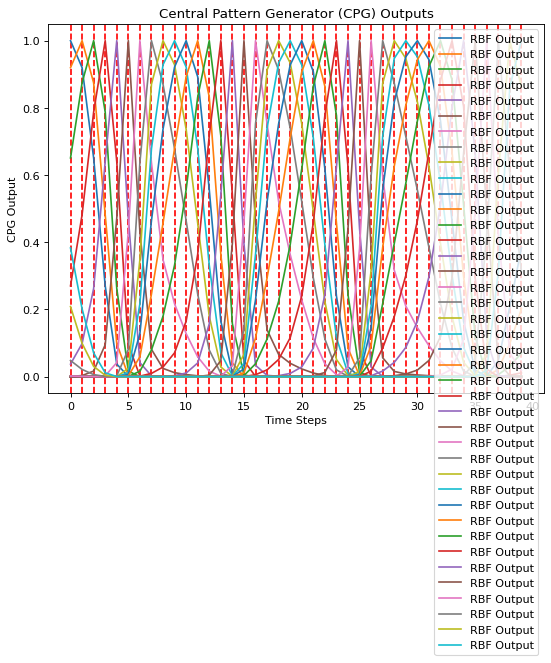

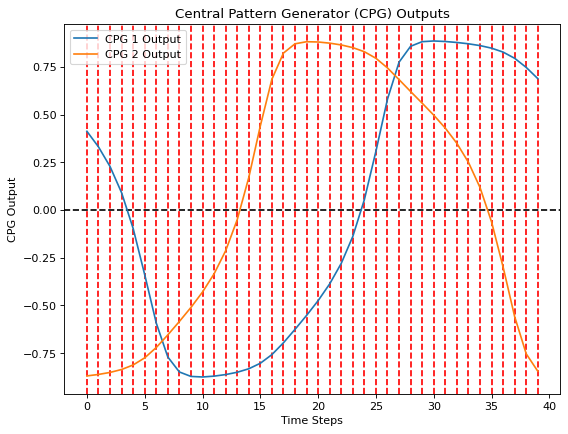

In [112]:
print(means_kern_pos)
print(kernels[0])
# Plotting
plt.figure(figsize=(8, 6), dpi=80)
for i in range(len(means_kern_pos)):
    plt.axvline(x=means_kern_pos[i], color='r', linestyle='--')
for i in range(N_KERNELS):
    plt.plot(x, kernels[i], label='RBF Output')
#plt.plot(x, output_1_cpg, label='CPG 1 Output')
#plt.plot(x, output_2_cpg, label='CPG 2 Output')
plt.xlabel('Time Steps')
plt.ylabel('CPG Output')
plt.title('Central Pattern Generator (CPG) Outputs')
plt.legend()
plt.show()

plt.figure(figsize=(8, 6), dpi=80)
for i in range(len(means_kern_pos)):
    plt.axvline(x=means_kern_pos[i], color='r', linestyle='--')
plt.axhline(y=0, color='k', linestyle='--')
plt.plot(x, output_1_cpg, label='CPG 1 Output')
plt.plot(x, output_2_cpg, label='CPG 2 Output')
#plt.plot(x, centers_df[0], label='RBF Centers')
#plt.plot(x, centers_df[1], label='RBF Centers')
#plt.plot(x,S1, label='S1')
#plt.plot(x,S2, label='S2')
plt.xlabel('Time Steps')
plt.ylabel('CPG Output')
plt.title('Central Pattern Generator (CPG) Outputs')
plt.legend()
plt.show()


[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39]
[1.00000000e+00 8.67276904e-01 4.70706426e-01 1.20614559e-01
 1.66369629e-02 2.53917974e-03 5.50490502e-04 7.71775194e-05
 2.53313793e-06 3.71292423e-08 2.93115021e-09 1.94030902e-09
 3.36612521e-09 7.71302568e-09 1.90245955e-08 4.84069039e-08
 1.23263882e-07 2.77409701e-07 3.76938543e-07 1.53055213e-07
 1.73790403e-08 3.35158810e-09 3.32245355e-09 8.62384105e-09
 3.19952985e-08 1.41054495e-07 7.25178991e-07 4.24300889e-06
 2.29645384e-05 6.16492944e-05 4.13978424e-05 1.61877282e-05
 1.57936072e-05 3.32306890e-05 8.92817448e-05 2.52274317e-04
 7.31283091e-04 2.19232698e-03 6.54607883e-03 1.58916106e-02]
[0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01]


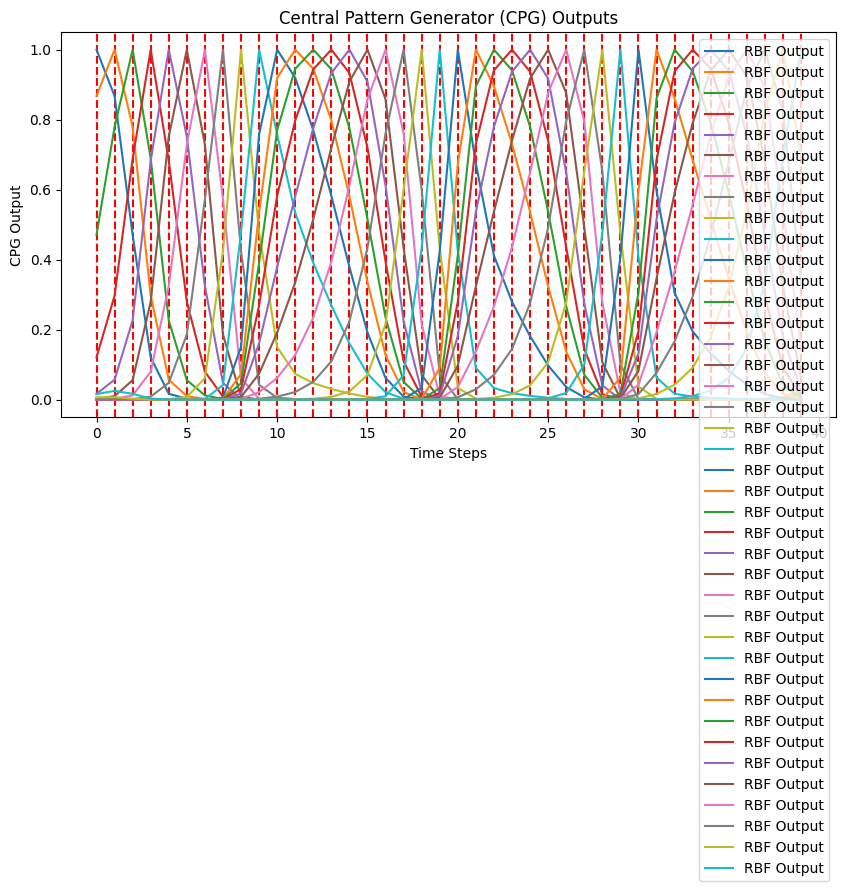

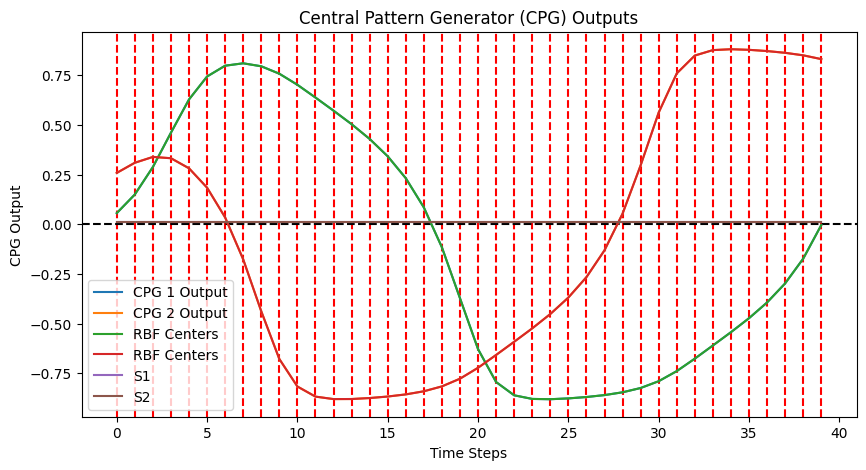

In [64]:
print(means_kern_pos)
print(kernels[0])
print (S1)
# Plotting
plt.figure(figsize=(10, 5))
for i in range(len(means_kern_pos)):
    plt.axvline(x=means_kern_pos[i], color='r', linestyle='--')
for i in range(N_KERNELS):
    plt.plot(x, kernels[i], label='RBF Output')
#plt.plot(x, output_1_cpg, label='CPG 1 Output')
#plt.plot(x, output_2_cpg, label='CPG 2 Output')
plt.xlabel('Time Steps')
plt.ylabel('CPG Output')
plt.title('Central Pattern Generator (CPG) Outputs')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
for i in range(len(means_kern_pos)):
    plt.axvline(x=means_kern_pos[i], color='r', linestyle='--')
plt.axhline(y=0, color='k', linestyle='--')
plt.plot(x, output_1_cpg, label='CPG 1 Output')
plt.plot(x, output_2_cpg, label='CPG 2 Output')
plt.plot(x, centers_df[0], label='RBF Centers')
plt.plot(x, centers_df[1], label='RBF Centers')
plt.plot(x,S1, label='S1')
plt.plot(x,S2, label='S2')
plt.xlabel('Time Steps')
plt.ylabel('CPG Output')
plt.title('Central Pattern Generator (CPG) Outputs')
plt.legend()
plt.show()


In [16]:
if Write_to_csv:
    output_predictions_df.to_csv(filename + prediction_suffix + ".csv", index=False)
    W_trained_df.to_csv(filename + weights_suffix + ".csv", index=False)
    centers_df.to_csv(filename + centers_suffix + ".csv", index=False, header=False)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39]
[1.00000000e+00 8.67276904e-01 4.70706426e-01 1.20614559e-01
 1.66369629e-02 2.53917974e-03 5.50490502e-04 7.71775194e-05
 2.53313793e-06 3.71292423e-08 2.93115021e-09 1.94030902e-09
 3.36612521e-09 7.71302568e-09 1.90245955e-08 4.84069039e-08
 1.23263882e-07 2.77409701e-07 3.76938543e-07 1.53055213e-07
 1.73790403e-08 3.35158810e-09 3.32245355e-09 8.62384105e-09
 3.19952985e-08 1.41054495e-07 7.25178991e-07 4.24300889e-06
 2.29645384e-05 6.16492944e-05 4.13978424e-05 1.61877282e-05
 1.57936072e-05 3.32306890e-05 8.92817448e-05 2.52274317e-04
 7.31283091e-04 2.19232698e-03 6.54607883e-03 1.58916106e-02]


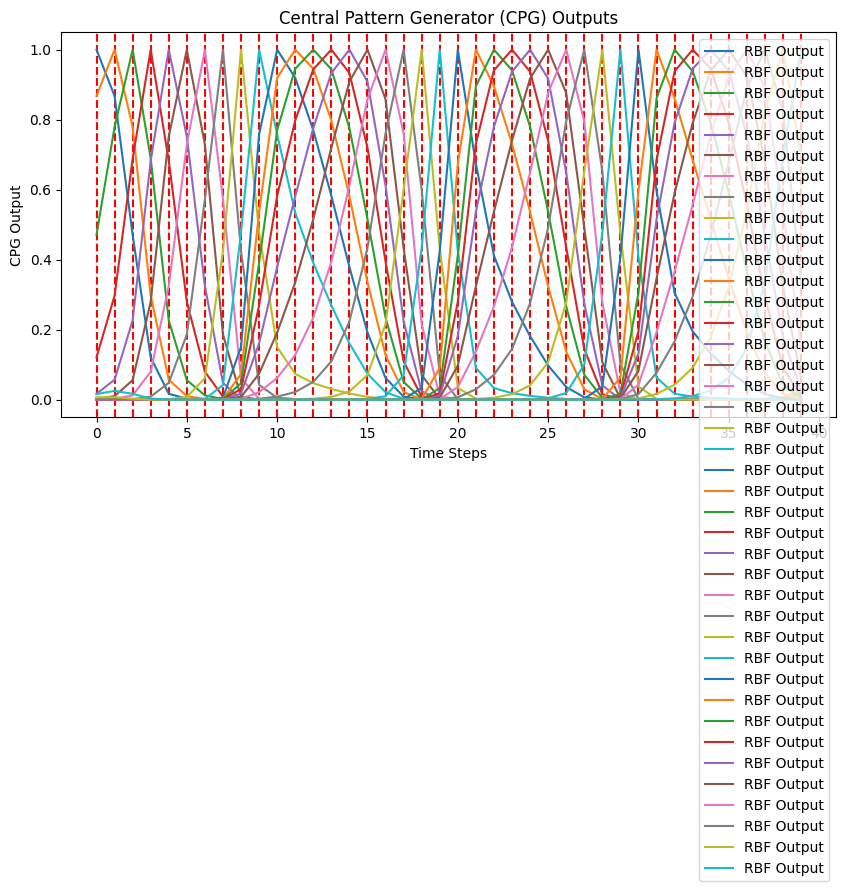

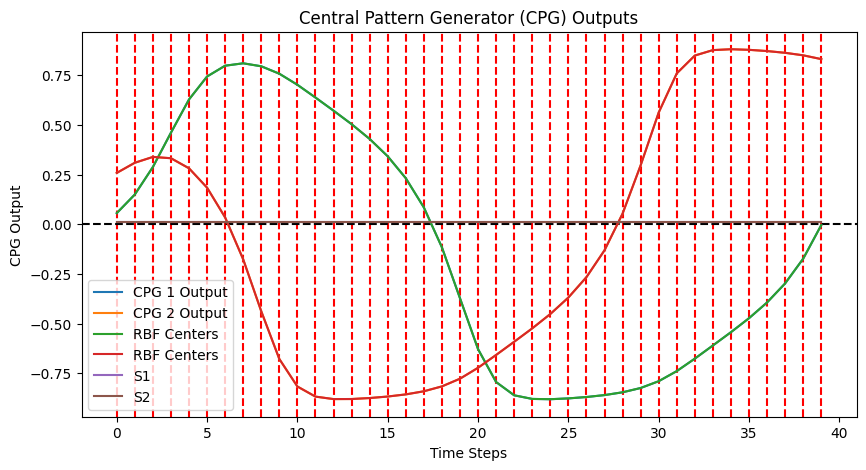

In [67]:
print(means_kern_pos)
print(kernels[0])
# Plotting
plt.figure(figsize=(10, 5))
for i in range(len(means_kern_pos)):
    plt.axvline(x=means_kern_pos[i], color='r', linestyle='--')
for i in range(N_KERNELS):
    plt.plot(x, kernels[i], label='RBF Output')
#plt.plot(x, output_1_cpg, label='CPG 1 Output')
#plt.plot(x, output_2_cpg, label='CPG 2 Output')
plt.xlabel('Time Steps')
plt.ylabel('CPG Output')
plt.title('Central Pattern Generator (CPG) Outputs')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
for i in range(len(means_kern_pos)):
    plt.axvline(x=means_kern_pos[i], color='r', linestyle='--')
plt.axhline(y=0, color='k', linestyle='--')
plt.plot(x, output_1_cpg, label='CPG 1 Output')
plt.plot(x, output_2_cpg, label='CPG 2 Output')
plt.plot(x, centers_df[0], label='RBF Centers')
plt.plot(x, centers_df[1], label='RBF Centers')
plt.plot(x,S1, label='S1')
plt.plot(x,S2, label='S2')
plt.xlabel('Time Steps')
plt.ylabel('CPG Output')
plt.title('Central Pattern Generator (CPG) Outputs')
plt.legend()
plt.show()


## Targetvs Output

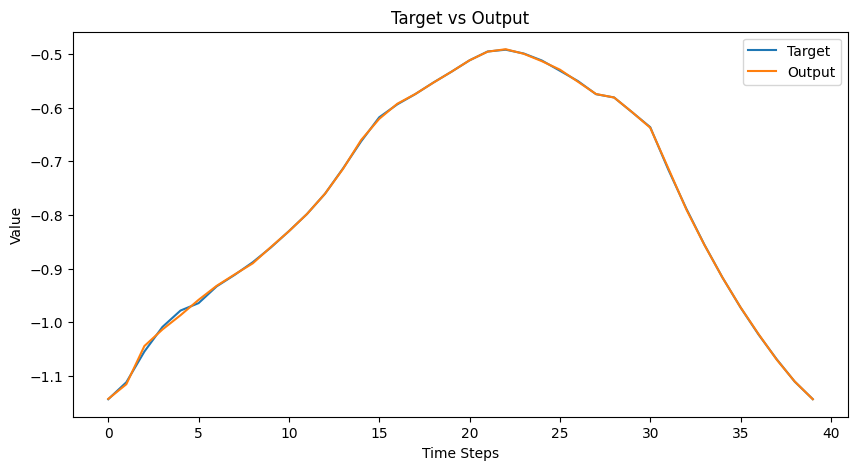

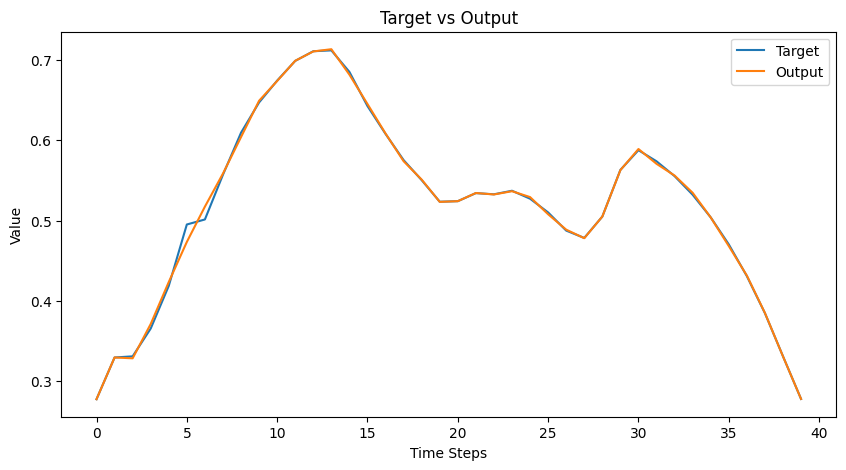

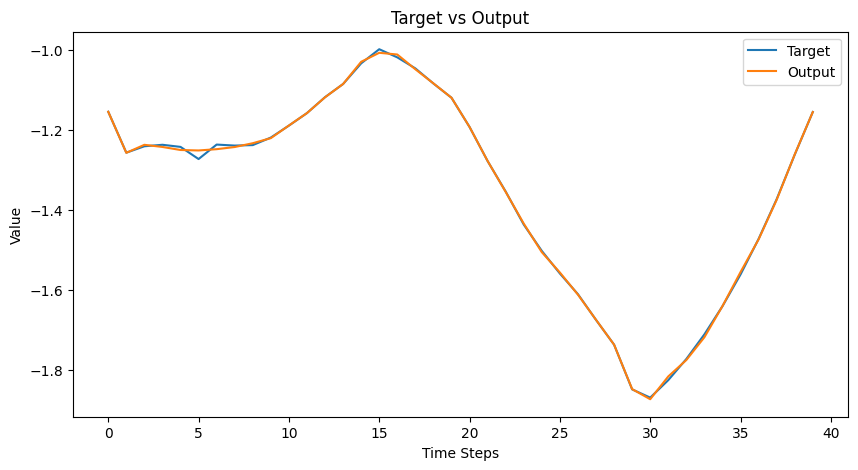

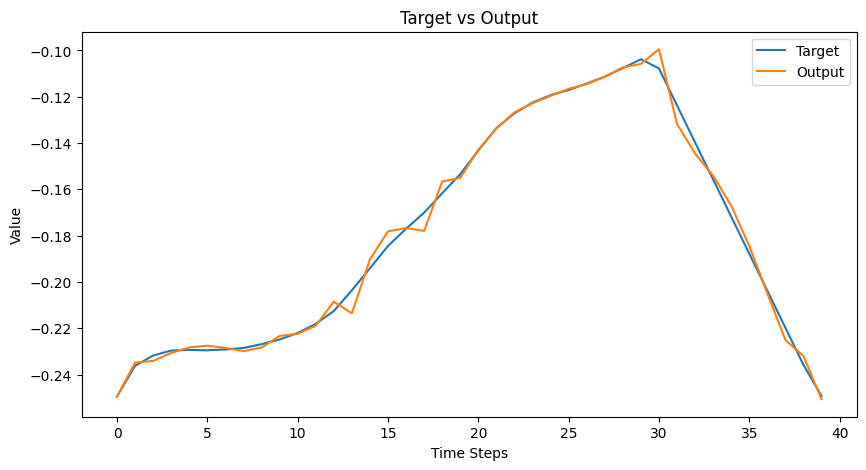

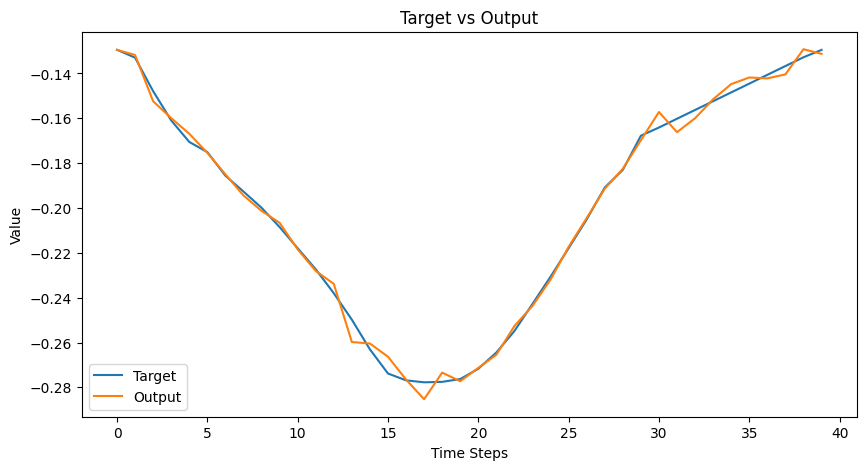

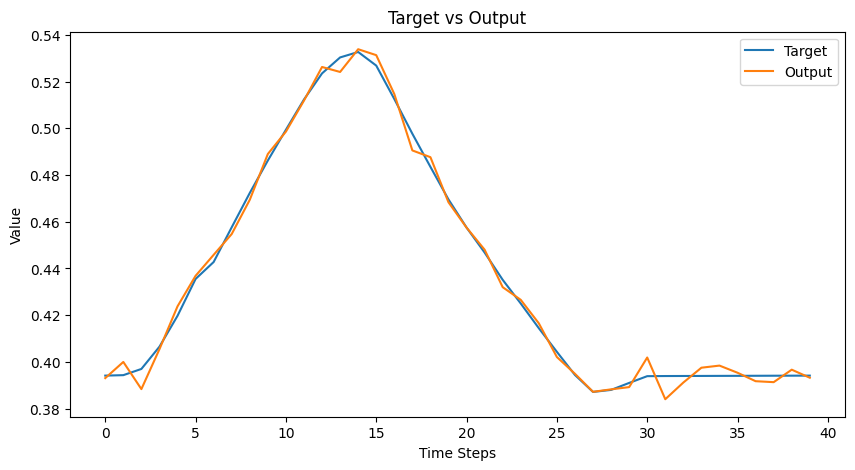

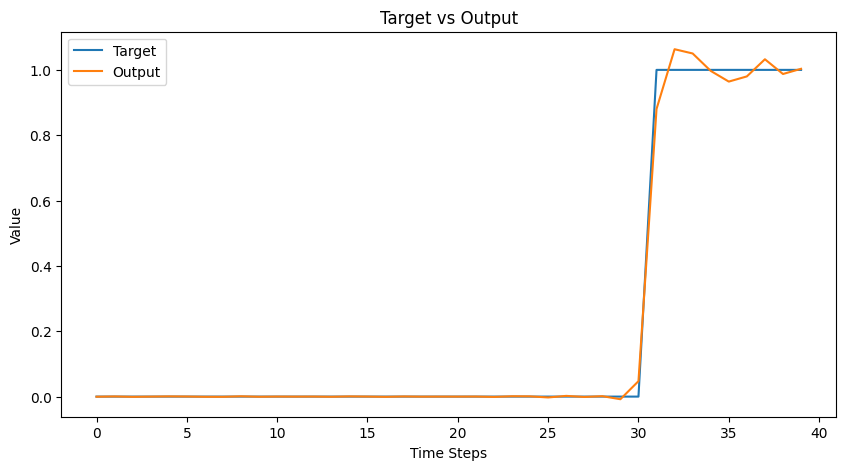

In [7]:
df_1 = pd.read_csv(filename + prediction_suffix + '.csv')

for column in df.columns:
    target = df[column].values 
    prediction = df_1[column].values

    plt.figure(figsize=(10, 5))
    plt.plot(x, target, label='Target')
    plt.plot(x, prediction, label='Output')

    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Data from CSV')
    plt.xlabel('Time Steps')
    plt.ylabel('Value')
    plt.title('Target vs Output')
    plt.legend()
    plt.show()

## Tidy up the csv files in the same format as medaextra_ver2

In [8]:
import numpy as np
predictions = [dir + filenames[0] + prediction_suffix + '.csv',dir + filenames[1] + prediction_suffix + '.csv', dir + filenames[2] + prediction_suffix + '.csv']
weights = [dir + filenames[0] + weights_suffix + '.csv', dir + filenames[1] + weights_suffix + '.csv', dir + filenames[2] + weights_suffix + '.csv']
centers_list = [dir + filenames[0] + centers_suffix + '.csv', dir + filenames[1] + centers_suffix + '.csv', dir + filenames[2] + centers_suffix + '.csv']


df_centers = pd.read_csv(centers_list[1])
#df_centers = df_centers[[df_centers.columns[1], df_centers.columns[0]]]
df_centers.to_csv('rbfn_centers_gian.txt', index=False, header=False)



if Tidy_up:
    i=0
    j=3
    for weight in weights:
        df = pd.read_csv(weight)
        df = df.drop(columns=[df.columns[3], df.columns[4],df.columns[5]])
        concatenated_column = df.values.flatten()
        with open('rbfn_weights_gian_' + str(i) + '.txt', 'w') as file:
            for colum in df.columns:
                for value in df[colum]:
                    #value = round(value, 7)
                    file.write(str(value) + '\n')
                file.write('\n')

        with open('rbfn_weights_gian_' + str(j) + '.txt', 'w') as file:
            for colum in df.columns:
                for value in df[colum]:
                    #value = round(value, 7)
                    file.write(str(value) + '\n')
                file.write('\n')
        i+=1
        j+=1
    

In [9]:
print(df.columns)

Index(['jointHR1', 'jointHR2', 'jointHR3', 'force_sign_HR'], dtype='object')


## Compare the files with Joes

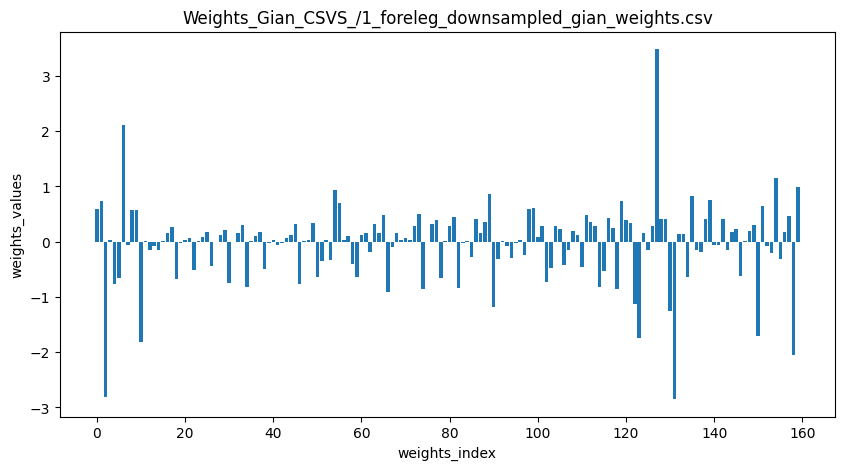

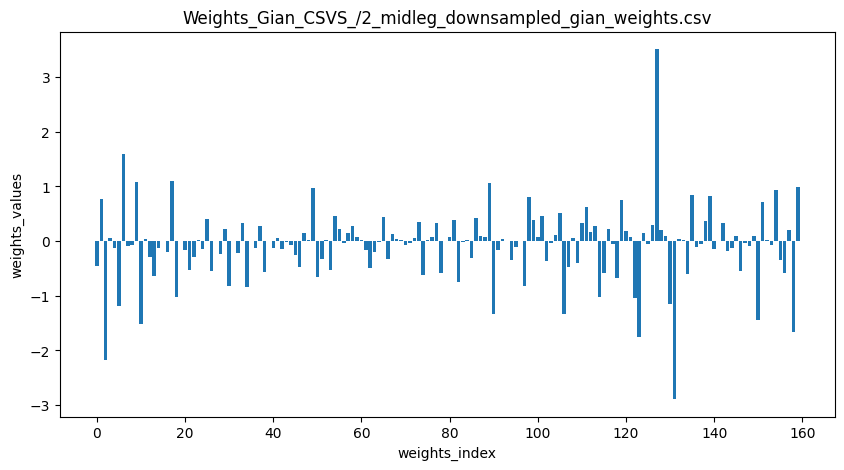

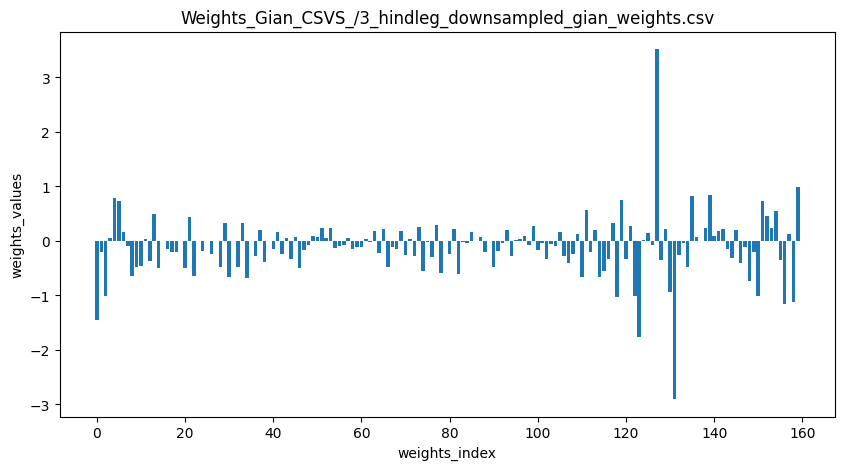

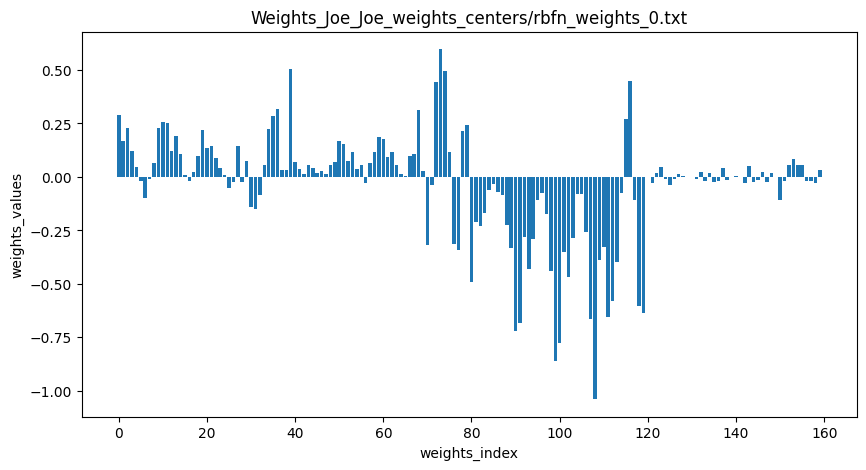

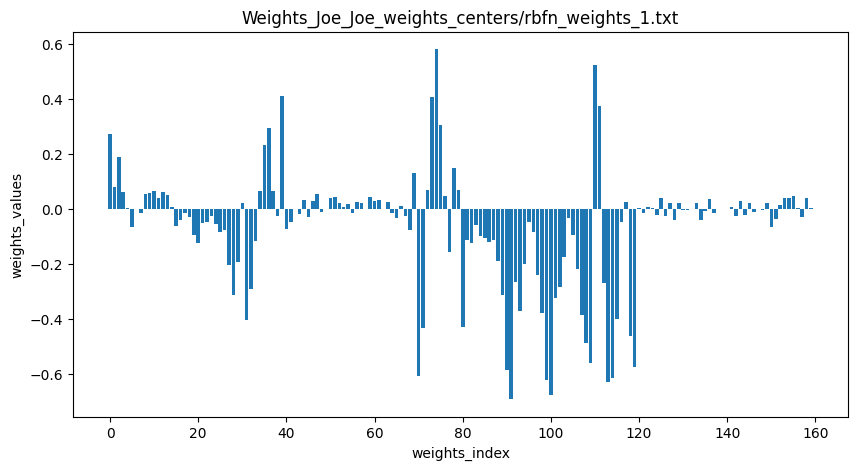

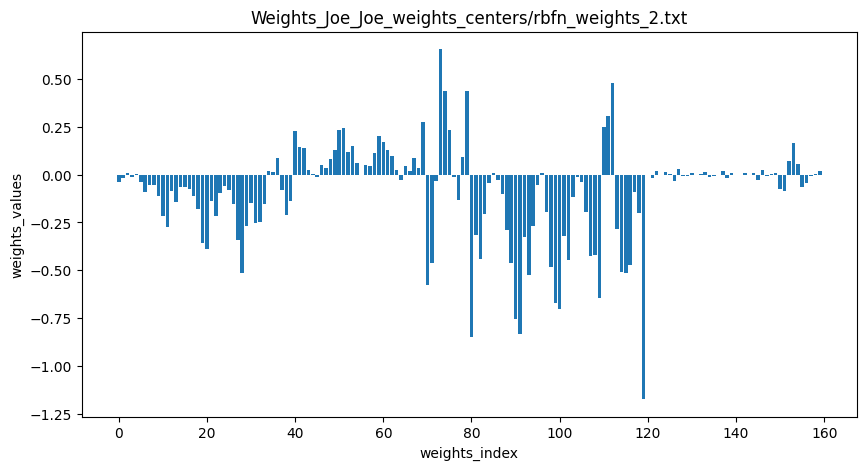

In [72]:
for weight in weights:
    df = pd.read_csv(weight)
    df = df.drop(columns=[df.columns[3], df.columns[4],df.columns[5]])
    concatenated_column = df.values.flatten()
    plt.figure(figsize=(10, 5))
    plt.bar(range(len(concatenated_column)), concatenated_column)
    plt.xlabel('weights_index')
    plt.ylabel('weights_values')
    plt.title('Weights_Gian_'+ weight)

output_list = []

Joes = ['Joe_weights_centers/rbfn_weights_0.txt', 'Joe_weights_centers/rbfn_weights_1.txt', 'Joe_weights_centers/rbfn_weights_2.txt']
for joe in Joes:
    with open(joe) as file:
        for line in file:
            line = line.strip()
            if line:
                try:
                    value = float(line)
                    output_list.append(value)
                except ValueError:
                    print(f"Invalid value: {line}")
        file.close()
    plt.figure(figsize=(10, 5))
    plt.bar(range(len(output_list)), output_list)
    plt.xlabel('weights_index')
    plt.ylabel('weights_values')
    plt.title('Weights_Joe_'+ joe)
    output_list = []

## Compare the files with Joe

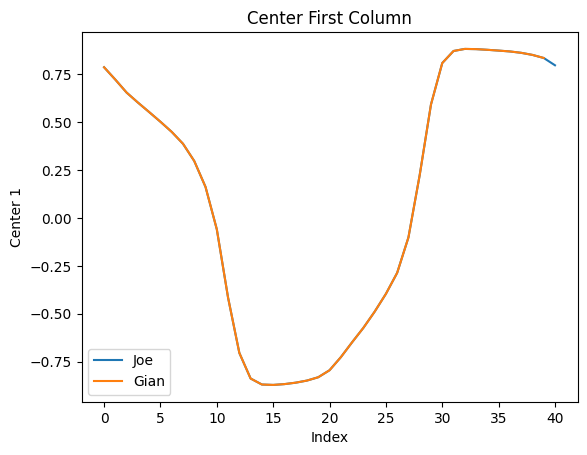

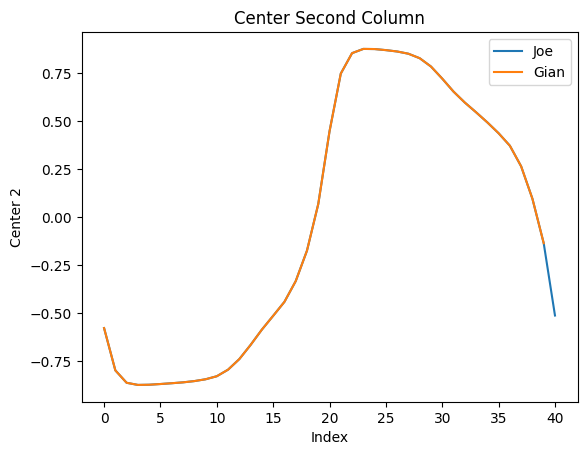

In [11]:
import numpy as np
# Read the .txt file
data = np.loadtxt('Joe_weights_centers/rbfn_centers.txt', delimiter=',')
data_gian = np.loadtxt('rbfn_centers_gian.txt', delimiter=',')

# Separate the columns
column1 = data[:, 0]
column2 = data[:, 1]
column3 = data_gian[:,0]
column4 = data_gian[:,1]

# Plot the first column
plt.figure()
plt.plot(column1)
plt.plot(column3)
plt.xlabel('Index')
plt.ylabel('Center 1')
plt.legend(["Joe", "Gian"])
plt.title('Center First Column')


# Plot the second column
plt.figure()
plt.plot(column2)
plt.plot(column4)

plt.plot()
plt.xlabel('Index')
plt.ylabel('Center 2')
plt.legend(["Joe", "Gian"])
plt.title('Center Second Column')

# Show the plots
plt.show()


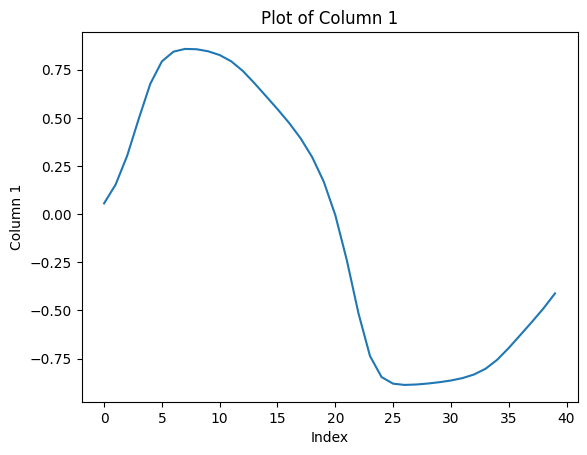

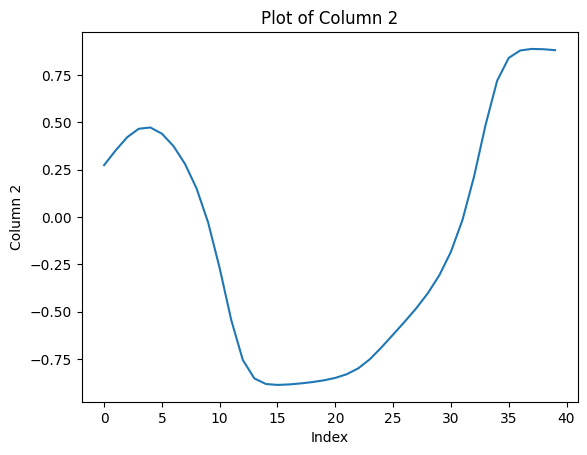

In [19]:
import numpy as np
# Read the .txt file


# Separate the columns
column1 = data[:, 0]
column2 = data[:, 1]

# Plot the first column
plt.figure()
plt.plot(column1)
plt.xlabel('Index')
plt.ylabel('Column 1')
plt.title('Plot of Column 1')

# Plot the second column
plt.figure()
plt.plot(column2)
plt.xlabel('Index')
plt.ylabel('Column 2')
plt.title('Plot of Column 2')

# Show the plots
plt.show()
